In [3]:
import sys, os

# Get project root (parent of the current notebook folder)
project_root = os.path.abspath("..")

# Add to Python path
if project_root not in sys.path:
    sys.path.append(project_root)

print("Added to path:", project_root)


Added to path: c:\Users\asus\OneDrive\EV-projects\evcs-projects


In [ ]:
import time
import numpy as np
import pandas as pd

from evcs.geom import build_arcs
from evcs.model import build_base_model
from evcs.methods import (
    evaluate_solution,            # scoring
    build_initial_solution_weighted,
    local_search,                 # LS refinement
    destroy_partial,              # random destroy
    reconstruction_greedy,        # W1/W2 reconstruction
)
from scripts.randomInstance import load_instance

def iterated_local_search_pipeline(
    inst,
    policy="closest_only",
    D=3.0,
    time_limit=1200,              # seconds for the whole ILS loop
    k_destroy=10,                 # how many stations to remove per cycle
    init_mode="weighted_W1",     # "weighted_W1" | "weighted_W2"
    reconstruct_mode="weighted_W2",
    ls_max_iter=20,
    forbid_self=False,
    verbose=True,
):
    # ---------- Unpack the instance ----------
    coords_I, coords_J = inst["coords_I"], inst["coords_J"]
    I_idx, J_idx = inst["I_idx"], inst["J_idx"]
    demand_I = inst["demand_I"]
    M, N = len(I_idx), len(J_idx)

    # ---------- Build arcs & base model ----------
    distIJ, in_range, Ji, Ij = build_arcs(
        coords_I, coords_J, D=D, forbid_self=forbid_self,
        I_idx=I_idx, J_idx=J_idx
    )
    # choose defaults (same as your batch helpers)
    P = max(2, int(round((N ** 0.5) / 1.2)))
    avg_demand = 3.0
    Q = (N * avg_demand) / max(1, P)

    m = build_base_model(
        M, N, in_range, Ji, Ij, demand_I, Q, P,
        distIJ=distIJ, method_name=policy
    )

    # ---------- Initial solution (W1/W2) ----------
    if init_mode == "weighted_W2":
        m = build_initial_solution_weighted(
            m, distIJ, demand_I, method_name=policy, weight_mode="W2"
        )
    else:
        m = build_initial_solution_weighted(
            m, distIJ, demand_I, method_name=policy, weight_mode="W1"
        )

    # First LS polish
    m = local_search(
        m, distIJ, in_range, Ji, Ij, farther_of={},  # farther_of not needed for closest_only scoring
        method_name=policy, max_iter=ls_max_iter,
        improvement_rule="first", try_order="random", logger=None
    )

    met = evaluate_solution(m, distIJ, demand_I, method_name=policy)
    best_score = met["covered_demand"]
    best_model = m.clone()

    if verbose:
        print(f"ILS start: N={N}, P={P}, best={best_score:.3f}")

    # ---------- Continuous D&R cycles ----------
    t0 = time.time()
    log_rows = []
    it = 0
    while time.time() - t0 < time_limit:
        it += 1

        # 1) start from the BEST solution so far
        cand = best_model.clone()

        # 2) destroy k sites (random for now; add smarter ones later)
        cand = destroy_partial(cand, k=k_destroy)

        # 3) reconstruct to fill back to P using W1/W2
        cand = reconstruction_greedy(
            cand, distIJ, demand_I, D, policy, greedy_mode=reconstruct_mode
        )

        # 4) LS polish
        cand = local_search(
            cand, distIJ, in_range, Ji, Ij, farther_of={},
            method_name=policy, max_iter=ls_max_iter,
            improvement_rule="first", try_order="random", logger=None
        )

        # 5) score & accept if better
        met_c = evaluate_solution(cand, distIJ, demand_I, method_name=policy)
        cand_score = met_c["covered_demand"]

        elapsed = time.time() - t0
        improved = cand_score > best_score + 1e-9
        if improved:
            best_score = cand_score
            best_model = cand.clone()

        log_rows.append(dict(
            iter=it, time=elapsed, score=cand_score,
            best=best_score, improved=int(improved)
        ))

        if verbose:
            print(f"[{it:02d}] score={cand_score:.3f} | best={best_score:.3f} | t={elapsed:.1f}s")

    log_df = pd.DataFrame(log_rows)
    return best_model, best_score, log_df


In [ ]:
from scripts.randomInstance import load_instance
from pathlib import Path

seeds = [1, 11, 21]
N =80               # or 120 / 200 per your experiments
policy = "closest_only"
D = 2.8 if N > 60 else 3.5

rows = []
for sd in seeds:
    inst_path = Path(f"data/small/inst_N{N}_seed{sd}.json")
    inst = load_instance(inst_path)

    best_model, best_score, log_df = iterated_local_search_pipeline(
        inst,
        policy=policy,
        D=D,
        time_limit=1200,          # try 180–600s for bigger N
        k_destroy=10,             # try {2,3,5}
        init_mode="weighted_W1", # try "weighted_W2" too
        reconstruct_mode="weighted_W2",
        ls_max_iter=20,
        verbose=True
    )

    rows.append(dict(N=N, seed=sd, policy=policy, best_score=best_score))
    # save the improvement curve per seed
    log_df.to_csv(f"results/ils_curve_N{N}_seed{sd}.csv", index=False)

pd.DataFrame(rows).to_csv(f"results/ils_summary_N{N}.csv", index=False)
print(pd.DataFrame(rows))


→ Added 'closest_only' constraints.
✅ Weighted greedy (W1) initialized with 7 stations.

🔵 Local Search start (closest_only), initial obj=177.365
Iter 01: open/close 3->31 → 194.971
Iter 02: open/close 63->47 → 199.351
Iter 03: open/close 22->54 → 217.202
Iter 04: open/close 44->23 → 218.692
Iter 05: open/close 59->15 → 218.760
Iter 06: open/close 31->43 → 220.197
Iter 07: open/close 43->18 → 225.005
Iter 08: open/close 62->32 → 229.760
Iter 09: open/close 18->48 → 231.174
↪️ Switching to next neighborhood: MERGE
↪️ Switching to next neighborhood: SHIFT
✅ Final objective (closest_only) = 231.174
ILS start: N=80, P=7, best=231.174

🔵 Local Search start (closest_only), initial obj=203.633
Iter 01: open/close 48->21 → 203.653
Iter 02: open/close 28->26 → 217.361
Iter 03: open/close 47->7 → 220.904
Iter 04: open/close 21->9 → 221.806
Iter 05: open/close 41->23 → 230.460
Iter 06: open/close 26->25 → 231.816
Iter 07: open/close 23->58 → 232.536
Iter 08: open/close 7->30 → 233.177
Iter 09: op

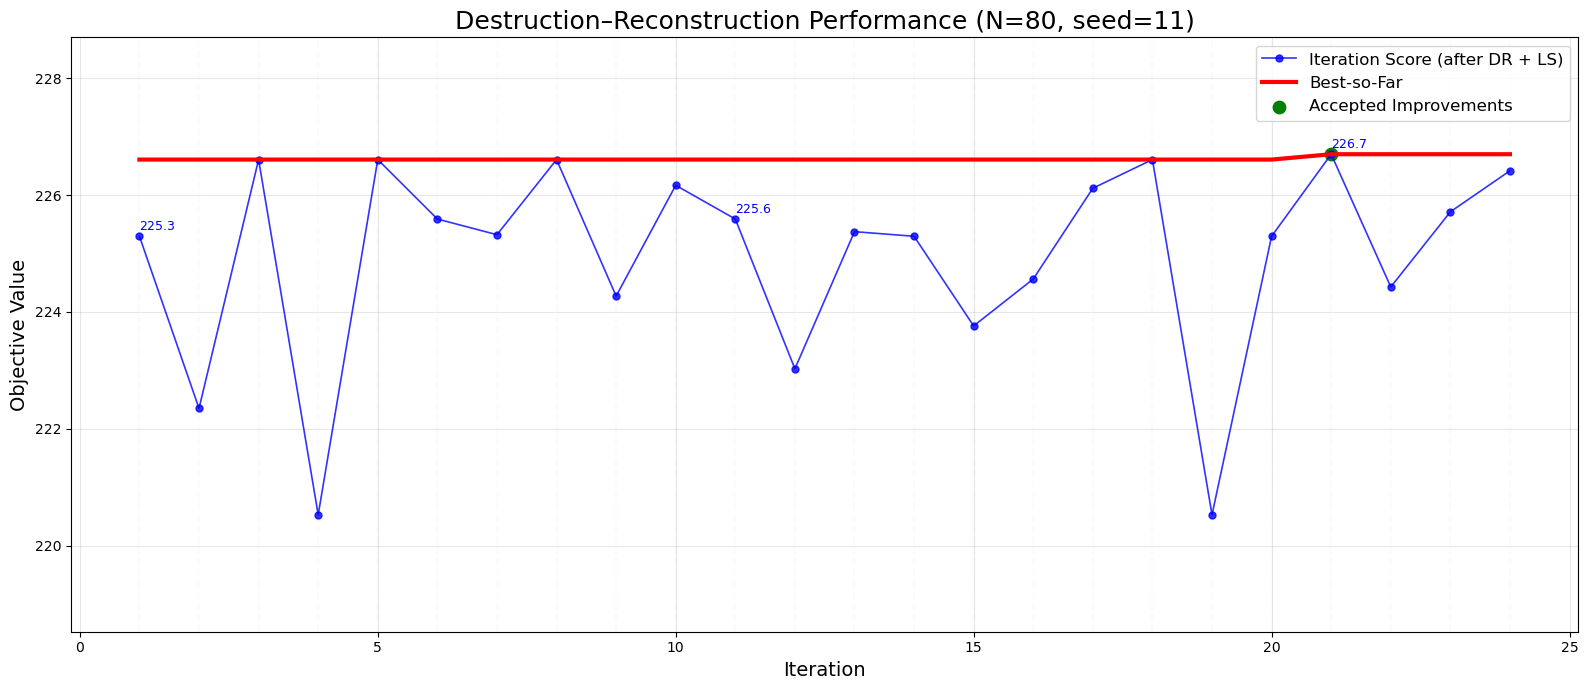

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_DR_final(log_df, N, seed):
    plt.figure(figsize=(16,7))

    # Vertical iteration separators
    for i in log_df["iter"]:
        plt.axvline(i, color='lightgray', linestyle='--', alpha=0.08)

    # Iteration final score
    plt.plot(
        log_df["iter"], log_df["score"],
        marker='o', markersize=5,
        linewidth=1.2, alpha=0.8,
        color='blue',
        label="Iteration Score (after DR + LS)"
    )

    # Best-so-far line
    plt.plot(
        log_df["iter"], log_df["best"],
        color='red', linewidth=3,
        label="Best-so-Far"
    )

    # Improvement markers
    improved = log_df[log_df["improved"] == 1]
    plt.scatter(
        improved["iter"], improved["best"],
        color='green', s=80, label="Accepted Improvements"
    )

    # Score labels occasionally
    for idx, row in log_df.iterrows():
        if idx % 10 == 0:
            plt.text(
                row["iter"], row["score"] + 0.1,
                f"{row['score']:.1f}",
                fontsize=9, color='blue'
            )

    # Nice Y-axis scaling
    y_min = log_df["score"].min() - 2   # bigger margin for N=80
    y_max = log_df["best"].max() + 2
    plt.ylim(y_min, y_max)

    # Titles and labels
    plt.title(f"Destruction–Reconstruction Performance (N={N}, seed={seed})",
              fontsize=18)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Objective Value", fontsize=14)

    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# ---- LOAD AND PLOT N=80 ----
df = pd.read_csv("results/ils_curve_N80_seed11.csv")   # CHANGE SEED HERE
plot_DR_final(df, N=80, seed=11)
